In [1]:
import numpy as np
# from torch.utils.data import Dataset
from datasets import Dataset
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, logging
from IPython.display import Image

## basics

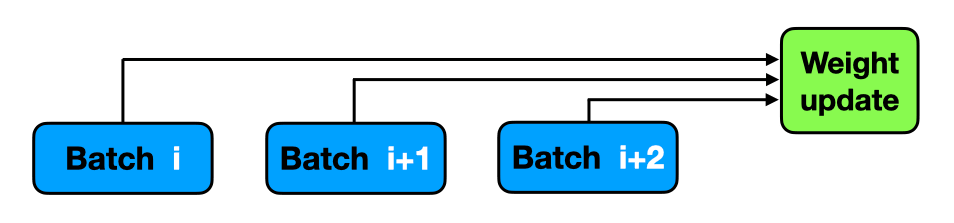

In [4]:
Image('../imgs/grad-accumulation.png', width=400)

- 显存占用优化算法
    - 可以在 `batch_size = 1` （或者是很小时）的时候，还能事实上提升真正的 `batch_size`
        - `batch_size = 1` （或者很小时）会导致训练过程的不稳定，收敛更慢，精度更低；

### Vanilla 

```
# loop through batches
for (inputs, labels) in data_loader:

    # extract inputs and labels
    inputs = inputs.to(device)
    labels = labels.to(device)

    # passes and weights update
    with torch.set_grad_enabled(True):
        
        # forward pass 
        preds = model(inputs)
        loss  = criterion(preds, labels)

        # backward pass
        loss.backward() 

        # weights update
        optimizer.step()
        optimizer.zero_grad()
```

### accumulation

```
gradient_accumulation_steps = 4

# loop through batches
for batch_idx, (inputs, labels) in enumerate(data_loader):

    # extract inputs and labels
    inputs = inputs.to(device)
    labels = labels.to(device)

    # passes and weights update
    with torch.set_grad_enabled(True):
        
        # forward pass 
        preds = model(inputs)
        loss = criterion(preds, labels)
        
        loss /= gradient_accumulation_steps
        
        # backward pass => compute gradient
        loss.backward() 
        
        if ((batch_idx + 1) % gradient_accumulation_steps == 0) or ((batch_idx+1) == len(data_loader)):
            # weights update
            optimizer.step()
            optimizer.zero_grad()
```

In [5]:
x = torch.tensor(1., requires_grad=True)
y = x**2

In [6]:
y.backward(retain_graph=True)
x.grad

tensor(2.)

In [7]:
y.backward()
x.grad

tensor(4.)

## demo

In [8]:
# !pip install nvidia-ml-py3
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    total_used = 0
    for i in range(torch.cuda.device_count()):
        handle = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(handle)
        total_used += info.used
    print(f"GPU memory occupied: {total_used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [9]:
print_gpu_utilization()

GPU memory occupied: 13166 MB.


### dataset

In [10]:
num_seqs = 1024
seq_len = 512
dummy_data = {
    'input_ids': np.random.randint(100, 30000, (num_seqs, seq_len)),
    'labels': np.random.randint(0, 2, (num_seqs))
}
ds = Dataset.from_dict(dummy_data)
ds.set_format('pt')

In [11]:
set(ds['labels'].numpy())

{0, 1}

### load model

In [ ]:
import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

In [12]:
model = AutoModelForSequenceClassification.from_pretrained('bert-large-uncased').to('cuda')

In [13]:
print_gpu_utilization()

GPU memory occupied: 13166 MB.


In [ ]:
# model

### training args & trainer

In [ ]:
logging.set_verbosity_error()
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}
training_args = TrainingArguments(per_device_train_batch_size=4, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=ds)
result = trainer.train()
print_summary(result)

```
{'train_runtime': 38.0194, 'train_samples_per_second': 26.934, 'train_steps_per_second': 3.367, 'train_loss': 0.7216147780418396, 'epoch': 1.0}
Time: 38.02
Samples/second: 26.93
GPU memory occupied: 21296 MB.
```

#### gradient accumulation

In [3]:
import numpy as np
# from torch.utils.data import Dataset
from datasets import Dataset
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, logging
from IPython.display import Image


from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    total_used = 0
    for i in range(torch.cuda.device_count()):
        handle = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(handle)
        total_used += info.used
    print(f"GPU memory occupied: {total_used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

num_seqs = 1024
seq_len = 512
dummy_data = {
    'input_ids': np.random.randint(100, 30000, (num_seqs, seq_len)),
    'labels': np.random.randint(0, 2, (num_seqs))
}
ds = Dataset.from_dict(dummy_data)
ds.set_format('pt')

model = AutoModelForSequenceClassification.from_pretrained('bert-large-uncased').to('cuda')

logging.set_verbosity_error()
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}
training_args = TrainingArguments(per_device_train_batch_size=1, gradient_accumulation_steps=4, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=ds)
result = trainer.train()
print_summary(result)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

{'train_runtime': 102.8176, 'train_samples_per_second': 9.959, 'train_steps_per_second': 1.245, 'train_loss': 0.7096406817436218, 'epoch': 1.0}
Time: 102.82
Samples/second: 9.96
GPU memory occupied: 13166 MB.


```
{'train_runtime': 102.8176, 'train_samples_per_second': 9.959, 'train_steps_per_second': 1.245, 'train_loss': 0.7096406817436218, 'epoch': 1.0}
Time: 102.82
Samples/second: 9.96
GPU memory occupied: 13166 MB.
```